In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import math
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import datetime as dt 

In [2]:
courses = pd.read_csv('C:/Users/gabriel/Desktop/data/anonimized_courses.csv')
logs = pd.read_csv('C:/Users/gabriel/Desktop/data/anonimized_logs.csv')
regs = pd.read_csv('C:/Users/gabriel/Desktop/data/anonimized_registrations.csv')
sections = pd.read_csv('C:/Users/gabriel/Desktop/data/anonimized_sections.csv')
tasks = pd.read_csv('C:/Users/gabriel/Desktop/data/anonimized_tasks.csv')
users = pd.read_csv('C:/Users/gabriel/Desktop/data/anonimized_users.csv')

In [3]:
users.head()

,createdAt,special_flagged,uuid
0,2011-08-03,0,97665
1,2011-08-11,0,68492
2,2011-08-03,0,52463
3,2011-08-19,0,129570
4,2011-08-04,0,45524


In [4]:
courses.head()

,createdAt,level,publicatedAt,totalVideoTime,subCategory_id,situation,isProject,removedAt,uuid,substitute_uuid
0,2011-09-22,1,2011-09-22,51,30,PUBLISHED,0,NaN,588,NaN
1,2011-10-27,5,2011-10-27,72,21,PUBLISHED,0,NaN,840,NaN
2,2012-02-15,1,2012-02-15,112,1,PUBLISHED,0,NaN,764,NaN
3,2012-03-07,5,2012-03-07,83,21,PUBLISHED,0,NaN,720,NaN
4,2012-05-29,1,2012-05-29,70,48,PUBLISHED,0,NaN,937,NaN


In [5]:
logs.head()

,user_uuid,moment,kind,iterable_uuid
0,57928,2016-09-12,EXERCISE_ANSWERED,2918d775-73e8-4c33-a3b7-5f0726bbe3ca
1,73719,2016-09-12,EXERCISE_ANSWERED,1315cdde-14e1-412d-bc3b-5da04b7aa44a
2,38957,2016-09-12,EXERCISE_ANSWERED,2ec53649-0eae-4114-b21f-ad72d448180b
3,59788,2016-09-12,EXERCISE_ANSWERED,ad5ae7b6-918f-4dfe-8680-db2928fe732c
4,73719,2016-09-12,EXERCISE_ANSWERED,7e08ee37-3eb6-4412-a6dd-d01f5619d2a2


In [6]:
sections.head()

,number,active,uuid,course_uuid
0,1,1,3988,588
1,2,1,6725,588
2,3,1,3716,588
3,4,1,4125,588
4,5,1,5354,588


In [7]:
regs.head()

,user_uuid,course_uuid,createdAt,finishedAt,lastAccessDate,currentState
0,36802,113,2015-09-15 06:33:25,2015-09-28 21:54:56,2017-11-28 16:22:04,IN_PROGRESS
1,34892,764,2015-09-15 00:00:21,2016-03-01 14:11:05,2016-10-18 13:15:22,IN_PROGRESS
2,37440,764,2015-09-15 00:00:21,NaN,2015-09-15 00:00:21,IN_PROGRESS
3,58529,76,2015-09-15 00:00:20,NaN,2018-03-14 20:27:27,NOT_VISIBLE
4,48059,76,2015-09-15 00:00:20,NaN,2015-09-15 00:00:20,IN_PROGRESS


In [8]:
tasks.head()

,kind,duration,status,createdAt,uuid,course_uuid
0,VIDEO,31,ACTIVE,2015-10-21,21316,588
1,VIDEO,188,ACTIVE,2015-10-21,13646,588
2,HQ_EXPLANATION,0,ACTIVE,2015-10-21,45401,588
3,OPEN_QUESTION,0,ACTIVE,2015-10-21,37691,588
4,OPEN_QUESTION,0,ACTIVE,2015-10-21,9310,588


In [9]:
tasks['kind'].value_counts()

VIDEO              16366
SINGLE_CHOICE       9138
HQ_EXPLANATION      8853
TEXT_CONTENT        6599
OPEN_QUESTION       3075
MULTIPLE_CHOICE     1439
EXTRA_CONTENT          1
Name: kind, dtype: int64

In [10]:
logs['kind'].value_counts()

EXERCISE_ANSWERED      18000612
COURSE_FINISHED          426290
FORUM_POSTED              67213
FORUM_SOLVED              13963
CAREER_FINISHED           12514
DEGREE_FINISHED            9247
SUGGESTION_APPROVED        3558
PROJECT_APPROVED             74
Name: kind, dtype: int64

Análise dos alunos que interagem com a plataforma (através dos foruns):

In [11]:
logsForum = logs.copy()
logsForum.drop(['iterable_uuid'],axis=1,inplace=True)

logsForum = logsForum[logsForum.kind!='COURSE_FINISHED']
logsForum = logsForum[logsForum.kind!='CAREER_FINISHED']
logsForum = logsForum[logsForum.kind!='DEGREE_FINISHED']
logsForum = logsForum[logsForum.kind!='PROJECT_APPROVED']
logsForum = logsForum[logsForum.kind!='EXERCISE_ANSWERED']

logsForum['somaForum'] = logsForum.groupby(['user_uuid','moment'])['kind'].transform('count')
logsForum.drop_duplicates(subset=['user_uuid','moment'],inplace=True)
logsForum.drop(['kind'],axis=1,inplace=True)

logsForum.head()

,user_uuid,moment,somaForum
526,13258,2016-09-12,4
1010,119614,2016-09-12,2
1029,86326,2016-09-12,2
1755,85621,2016-09-12,1
1873,82046,2016-09-12,1


In [12]:
logsEx = logs[logs['user_uuid'].isin(logsForum['user_uuid'])]

logsEx = logsEx[logsEx.kind!='FORUM_SOLVED']
logsEx = logsEx[logsEx.kind!='FORUM_POSTED']
logsEx = logsEx[logsEx.kind!='SUGGESTION_APPROVED']

logsEx.drop(['iterable_uuid'],axis=1,inplace=True)
logsEx['somaEx'] = logsEx.groupby(['user_uuid','moment'])['kind'].transform('count')
logsEx.drop_duplicates(subset=['user_uuid','moment'],inplace=True)
logsEx.drop(['kind'],axis=1,inplace=True)
logsEx.head()

,user_uuid,moment,somaEx
0,57928,2016-09-12,47
2,38957,2016-09-12,2
16,117109,2016-09-12,3
20,88787,2016-09-12,3
21,16502,2016-09-12,11


In [13]:
teste = logsForum.merge(logsEx, left_on=['user_uuid','moment'], right_on=['user_uuid','moment'])
teste = teste[(teste['somaEx'] < 300)]
teste.head()

,user_uuid,moment,somaForum,somaEx
0,13258,2016-09-12,4,1
1,119614,2016-09-12,2,4
2,82046,2016-09-12,1,42
3,86063,2016-09-12,1,11
4,102848,2016-09-12,1,3


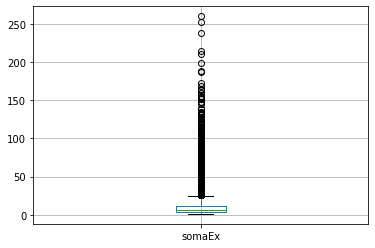

In [14]:
teste.boxplot(column='somaEx', return_type='axes')

In [15]:
teste['somaEx'].describe()

count    24059.000000
mean         9.953074
std         12.904675
min          1.000000
25%          3.000000
50%          6.000000
75%         12.000000
max        260.000000
Name: somaEx, dtype: float64

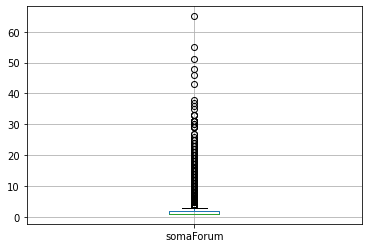

In [16]:
teste.boxplot(column='somaForum', return_type='axes')

In [17]:
teste['somaForum'].describe()

count    24059.000000
mean         1.787190
std          2.193431
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         65.000000
Name: somaForum, dtype: float64

In [18]:
activeYears = users[users['uuid'].isin(teste['user_uuid'])]
createdDates= [pd.to_datetime(d) for d in activeYears['createdAt']]
activeYears['yearsActive'] = [relativedelta(datetime.now(), d).years for d in createdDates]
activeYears['creationDate'] = [i for i in createdDates]
activeYears.drop(['createdAt','special_flagged'],axis=1,inplace=True)
activeYears.head()

<ipython-input-18-6bbc223fbf2b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  activeYears['yearsActive'] = [relativedelta(datetime.now(), d).years for d in createdDates]
<ipython-input-18-6bbc223fbf2b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  activeYears['creationDate'] = [i for i in createdDates]
C:\Users\gabriel\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

,uuid,yearsActive,creationDate
3,129570,9,2011-08-19
64,55367,9,2011-09-22
69,41377,9,2011-09-22
77,124499,9,2011-09-23
123,41067,9,2011-10-10


In [19]:
avgPosts = teste.merge(activeYears,left_on='user_uuid',right_on='uuid')
avgPosts.drop(['uuid'],axis=1,inplace=True)
avgPosts['moment'] = pd.to_datetime(avgPosts['moment'])
avgPosts['creationDate'] = pd.to_datetime(avgPosts['creationDate'])
avgPosts['avg'] = (avgPosts['somaEx']+avgPosts['somaForum'])/(avgPosts['moment'].dt.year - avgPosts['creationDate'].dt.year)
avgPosts.replace([np.inf, -np.inf], np.nan, inplace=True) 
avgPosts.dropna(inplace=True) 
  

avgPosts.head()

,user_uuid,moment,somaForum,somaEx,yearsActive,creationDate,avg
26,13258,2017-01-05,5,5,4,2016-07-22,10.0
27,13258,2017-01-06,7,6,4,2016-07-22,13.0
28,13258,2017-01-07,7,11,4,2016-07-22,18.0
29,13258,2017-01-09,11,14,4,2016-07-22,25.0
30,13258,2017-01-10,16,12,4,2016-07-22,28.0


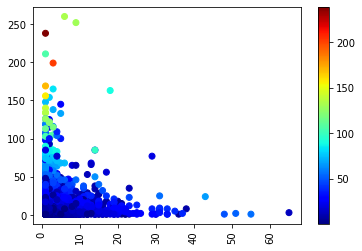

In [20]:
plt.scatter(x=avgPosts['somaForum'],y=avgPosts['somaEx'],c=avgPosts['avg'],cmap='jet')
plt.xticks(rotation='vertical')
plt.colorbar()
plt.show()

Com o plot de Forum X Exercícios acima, podemos perceber que não há uma correlação entre a atividade dos alunos nos fóruns e exercícios. Ademais, uma característica importante se tornou visível: conforme um aluno aumenta seu volume de atividades na plataforma, a tendência é que este se especialize em exercícios OU perguntas no fórum, nunca os dois juntos.

Relação entre tempo gasto em vídeo e quantidade de exercícios

In [21]:
tasksEx = logs.copy()

tasksEx = tasksEx[tasksEx.kind!='FORUM_SOLVED']
tasksEx = tasksEx[tasksEx.kind!='FORUM_POSTED']
tasksEx = tasksEx[tasksEx.kind!='SUGGESTION_APPROVED']

tasksEx.drop(['iterable_uuid'],axis=1,inplace=True)
tasksEx['somaEx'] = tasksEx.groupby(['user_uuid','moment'])['kind'].transform('count')
tasksEx.drop_duplicates(subset=['user_uuid','moment'],inplace=True)
tasksEx.drop(['kind'],axis=1,inplace=True)
tasksEx = tasksEx.merge(tasks[['duration','uuid']],left_on='user_uuid',right_on='uuid')
tasksEx.drop(['user_uuid'],axis=1,inplace=True)
tasksEx.head()

,moment,somaEx,duration,uuid
0,2016-09-12,47,192,57928
1,2016-09-13,13,192,57928
2,2016-09-14,28,192,57928
3,2016-09-15,6,192,57928
4,2016-09-16,8,192,57928


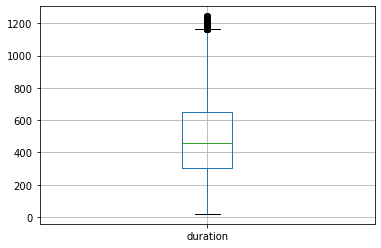

In [22]:
tasksEx = tasksEx[(tasksEx['duration'] > 0) & (tasksEx['duration'] < 1250) ]
tasksEx.boxplot(column='duration',return_type='axes')

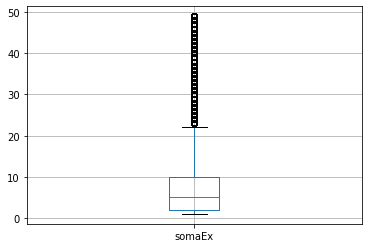

In [23]:
tasksEx = tasksEx[tasksEx['somaEx'] < 50]
tasksEx.boxplot(column='somaEx',return_type='axes')

In [24]:
tasksForumEx = tasksEx.merge(logsForum,left_on=['uuid','moment'],right_on=['user_uuid','moment'])
tasksForumEx.drop(['user_uuid'],axis=1,inplace=True)

In [25]:
tasksForumEx.head()

,moment,somaEx,duration,uuid,somaForum
0,2016-09-13,13,192,57928,1
1,2018-08-17,31,192,57928,1
2,2016-09-13,19,85,16791,1
3,2017-02-14,7,85,16791,1
4,2016-09-20,28,310,23131,1


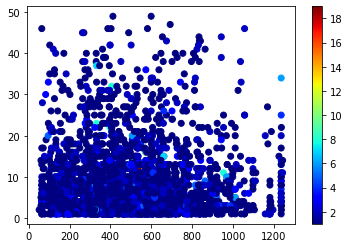

In [26]:
dates= [pd.to_datetime(d) for d in tasksForumEx['moment']]
plt.scatter(x=tasksForumEx['duration'],y=tasksForumEx['somaEx'],c=tasksForumEx['somaForum'],cmap='jet')
plt.colorbar()
plt.show()

Corroborando com o que foi dito anteriormente, aqui vemos, mais uma vez, a ausência de relação entre 

In [27]:
tasksForumEx.corr()

,somaEx,duration,uuid,somaForum
somaEx,1.000000,-0.022210,0.052386,-0.033022
duration,-0.022210,1.000000,0.036036,0.018567
uuid,0.052386,0.036036,1.000000,-0.043287
somaForum,-0.033022,0.018567,-0.043287,1.000000


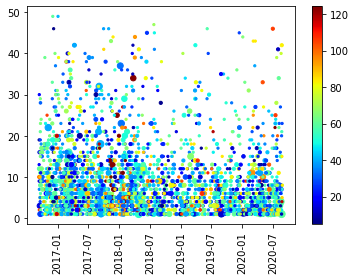

In [28]:
dates= [pd.to_datetime(d) for d in tasksForumEx['moment']]
du= [d/10 for d in tasksForumEx['duration']]
plt.scatter(x=dates,y=tasksForumEx['somaEx'],s=tasksForumEx['somaForum']*5,c=du,cmap='jet')
plt.xticks(rotation='vertical')
plt.colorbar()
plt.show()

Neste plot, percebemos algo interessante: o tempo que o aluno gasta em vídeo, representado no gráfico pela cor dos pontos, não tem correlação nem com a quantidade de exercícios feitos pelo aluno, nem com a atividade nos fóruns do mesmo. Ou seja, um aluno que assiste muitas aulas na plataforma não irá, necessáriamente, fazer muitos exercícios ou ser muito ativo nos fóruns online.

In [29]:
scores = avgPosts.copy()
scores['somaForum'] = scores.groupby('user_uuid')['somaForum'].transform('sum')
scores['somaEx'] = scores.groupby('user_uuid')['somaEx'].transform('sum')
scores['avg'] = (scores['somaForum']+scores['somaEx'])/(scores['yearsActive'])
scores.drop_duplicates(subset='user_uuid',inplace=True)
dscores = scores.merge(tasks,left_on='user_uuid',right_on='uuid')
dscores['duration'] = dscores.groupby('user_uuid')['duration'].transform('sum')
dscores.drop(['kind','status','course_uuid','uuid','createdAt'],axis=1,inplace=True)
dscores.head()

,user_uuid,moment,somaForum,somaEx,yearsActive,creationDate,avg,duration
0,13258,2017-01-05,184,263,4,2016-07-22,111.75,0
1,53284,2016-09-13,2,10,6,2014-01-09,2.00,981
2,27744,2017-11-15,1,15,4,2016-09-06,4.00,151
3,16791,2017-02-14,1,7,4,2016-08-01,2.00,85
4,57928,2018-08-17,1,31,4,2016-09-10,8.00,192


In [30]:
selectRegs = regs[['user_uuid','course_uuid']]
selectRegs = selectRegs[selectRegs['user_uuid'].isin(dscores['user_uuid'])]
testeScore = dscores.merge(selectRegs,left_on='user_uuid',right_on='user_uuid')
testeScore['courses'] = testeScore.groupby('user_uuid')['course_uuid'].transform('count')
testeScore.drop_duplicates(subset='user_uuid',inplace=True)
testeScore.head()

,user_uuid,moment,somaForum,somaEx,yearsActive,creationDate,avg,duration,course_uuid,courses
0,13258,2017-01-05,184,263,4,2016-07-22,111.75,0,801,28
28,53284,2016-09-13,2,10,6,2014-01-09,2.00,981,588,42
70,27744,2017-11-15,1,15,4,2016-09-06,4.00,151,843,16
86,16791,2017-02-14,1,7,4,2016-08-01,2.00,85,56,22
108,57928,2018-08-17,1,31,4,2016-09-10,8.00,192,375,7


Aqui, desenvolvemos uma metrica de score para os alunos

In [105]:
testeScore = testeScore[(testeScore['avg']<50) & (testeScore['avg']>0)]
testeScore = testeScore[testeScore['courses']>0]
testeScore = testeScore[(testeScore['duration']<1200) & (testeScore['duration']>0)]
normalEx = testeScore['somaEx']/testeScore['somaEx'].mean()
normalForum = testeScore['somaForum']/testeScore['somaForum'].mean()
normalDuration = testeScore['duration']/testeScore['duration'].mean()
normalCourses = testeScore['courses']/testeScore['courses'].mean()
testeScore['score'] = (normalEx+normalForum+normalDuration)/normalCourses

Após estabelecida a métrica, veremos dados a respeito de cada um dos quartis de pontuação

In [106]:
logFreq = logs[['user_uuid','moment']]
logFreq['entries'] = logFreq.groupby(['user_uuid','moment'])['moment'].transform('count')
logFreq.drop_duplicates(subset=['user_uuid','moment'],inplace=True)
logFreq['var'] = logFreq.groupby(['user_uuid'])['entries'].transform('var')
logFreq.head(10)

<ipython-input-106-b73ecb70f4a1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logFreq['entries'] = logFreq.groupby(['user_uuid','moment'])['moment'].transform('count')
<ipython-input-106-b73ecb70f4a1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logFreq.drop_duplicates(subset=['user_uuid','moment'],inplace=True)
<ipython-input-106-b73ecb70f4a1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

,user_uuid,moment,entries,var
0,57928,2016-09-12,47,976.858974
1,73719,2016-09-12,5,55.314407
2,38957,2016-09-12,2,30.077558
3,59788,2016-09-12,28,90.730488
5,61315,2016-09-12,12,10.500000
7,15131,2016-09-12,14,40.703815
8,4717,2016-09-12,3,276.800000
9,50945,2016-09-12,10,34.905138
11,100329,2016-09-12,37,92.705426
12,41837,2016-09-12,11,744.673831


In [107]:
scoreFreq = testeScore.merge(logFreq[['user_uuid','var','entries']],left_on='user_uuid',right_on='user_uuid')
scoreFreq['entries'] = scoreFreq.groupby(['user_uuid'])['entries'].transform('sum')
scoreFreq.drop_duplicates(subset='user_uuid',inplace=True)
scoreFreq.drop(['course_uuid'],axis=1,inplace=True)

In [108]:
scoreFreq.head()

,user_uuid,moment,somaForum,somaEx,yearsActive,creationDate,avg,duration,courses,score,var,entries
0,53284,2016-09-13,2,10,6,2014-01-09,2.0,981,42,2.477376,114.612987,416
56,27744,2017-11-15,1,15,4,2016-09-06,4.0,151,16,2.934830,21.509801,903
212,16791,2017-02-14,1,7,4,2016-08-01,2.0,85,22,1.294749,78.987805,357
254,57928,2018-08-17,1,31,4,2016-09-10,8.0,192,7,11.118681,976.858974,361
267,6338,2016-09-14,1,2,5,2015-06-27,0.6,1087,15,5.770098,21.362637,82


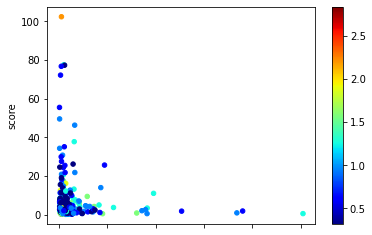

In [109]:
scoreFreq.plot(kind='scatter',x='var',y='score',colormap='jet',c=scoreFreq.yearsActive/scoreFreq.yearsActive.mean())
plt.show()

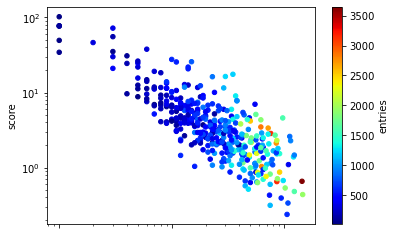

In [113]:
scoreFreq.plot(kind='scatter',x='courses',y='score',colormap='jet',c='entries',loglog=True)
plt.show()

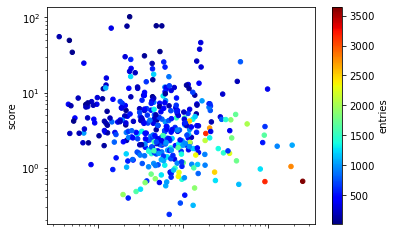

In [111]:
scoreFreq.plot(kind='scatter',x='var',y='score',colormap='jet',c='entries',loglog=True)
plt.show()

Iniciar aqui a seleção dos 25% mais ativos, utilizando o critério de mais tempo assistindo vídeos na plataforma:

In [ ]:
timeWatched = tasks[['duration','uuid']]
#remover 0 minutos (ruido)
timeWatched = timeWatched[(timeWatched['duration'] > 0) & (timeWatched['duration'] < 1500)]
timeWatched.sort_values(by='duration', ascending=False).head()

In [ ]:
timeWatched.boxplot(column='duration', return_type='axes')

In [ ]:
timeWatched.hist(column='duration',bins=30)

In [ ]:
#pegar os top 25% com mais tempo assistido
top25 = timeWatched.sort_values(by='duration', ascending=False).head(int(len(timeWatched)*0.25))
top25.head()

In [ ]:
top25.hist(column='duration', bins=30)

Acima, temos a distribuição do tempo em que os alunos do quartil superior gastam na plataforma (Tempo em minutos X quantidade de alunos)

In [ ]:
statuses = top25.merge(regs, left_on='uuid',right_on='user_uuid')
statuses.head()

In [ ]:
statuses = statuses[statuses.currentState!='NOT_VISIBLE']
statuses = statuses[statuses.currentState!='BOOKMARKED']

Aqui, fazemos a remoção de estados de curso irrelevantes para nossa análise, deixando apenas IN_PROGRESS e PAUSED a serem analisados

In [ ]:
#curso completado -> com data e in_progress // curso pausado -> resto
statuses['completion'] = np.where((statuses['currentState']=='IN_PROGRESS') & (statuses['finishedAt'].notna()), 'completed', 'paused')

In [ ]:
statuses.drop(['duration'],axis=1,inplace=True)
statuses.head()

In [ ]:
statuses.groupby('completion')['completion'].count().plot.pie(colors = ['green','yellow'], autopct='%1.1f%%',title='Course completion',)

In [ ]:
statuses.groupby('completion')['completion'].count()

Pelo gráfico, percebe-se que a maioria dos alunos os quais consideramos "os mais estudiosos" não completam seus cursos, mas sim os pausam em pontos arbitrários, sem necessáriamente haver um critério

In [ ]:
courses.head()

In [ ]:
courses.groupby('level')['level'].count()

In [ ]:
top25_courses = top25.merge(tasks, left_on='uuid',right_on='uuid')
top25_courses = top25_courses.merge(courses, left_on='course_uuid',right_on='uuid')
top25_courses.drop(['duration_x','duration_y','createdAt_x','createdAt_y','uuid_y'],axis=1,inplace=True)
top25_courses.head()

In [ ]:
top25_courses.groupby('level')['level'].count()

Temos abaixo o gráfico que ilustra uma predominância de cursos considerados "mais fáceis" dentre esse público.

In [ ]:
top25_courses.groupby('level')['level'].count().plot.pie(colors = ['green','orange','red'], autopct='%1.0f%%',title='Course difficulty')

In [ ]:
teste = statuses.merge(top25_courses, left_on='uuid',right_on='uuid_x')
teste.drop(['uuid_x', 'course_uuid_y'],axis=1,inplace=True)
teste['completion'] = teste['completion'].replace('completed', 1)
teste['completion'] = teste['completion'].replace('paused', 0)
teste['courseCount'] = teste.groupby('uuid')['course_uuid_x'].transform('count')
teste['completionRate'] = 100*teste.groupby(by=['uuid'])['completion'].transform('sum')/teste['courseCount']
teste = teste[['uuid','completionRate','courseCount']]
teste.drop_duplicates(subset=['uuid'],keep='first',inplace=True)
teste.head()

Finalmente, temos abaixo uma distribuição ta taxa de conclusão dos cursos entre os 25% mais ativos na plataforma.

In [ ]:
teste.hist(column='completionRate',bins=30)
plt.title('Taxa de completude dos cursos')

Percebemos aqui que, em par com o que já foi comentado anteriormente, a grande maioria dos alunos analisados não completa nem 20% dos cursos em que se inscreve.